<a href="https://colab.research.google.com/github/yzihan/Generative-AI/blob/main/notebooks/StyleCLIP_optimization_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/orpatashnik/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 605 (delta 78), reused 67 (delta 67), pack-reused 505
Receiving objects: 100% (605/605), 166.03 MiB | 43.09 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m5gxa4vy
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-m5gxa4vy
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=12fd878aee4eafa38eb283dd183f7389d41c0a55ed9fd75ff979e8770a0eccdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ive0_qf/wheels/fd/b9/c3/5b4470e35ed76e1

In [2]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'A person with purple hair' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}


In [3]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

In [4]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth"
}

In [5]:
if use_seed:
  import torch
  torch.manual_seed(seed)
from optimization.run_optimization import main
from argparse import Namespace
result = main(Namespace(**args))

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 51.7MiB/s]


Loading ResNet ArcFace


loss: 0.8105;:   0%|          | 0/40 [00:01<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
loss: 0.7402;: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


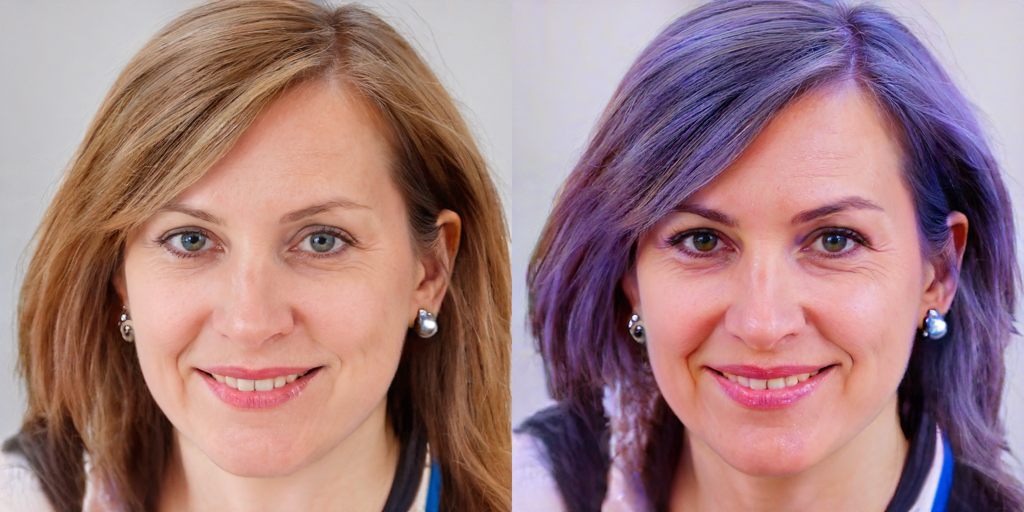

In [6]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [7]:
#@title Create and Download Video

!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>